In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Importo dataset

In [4]:
folder = 'dataset/'

In [6]:
train = pd.read_csv(folder+"train.csv")
test = pd.read_csv(folder+"test.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
submission = pd.read_csv(folder+"sample_submission.csv")

In [7]:
train[:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [8]:
train.shape

(159571, 8)

In [9]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [10]:
y[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Divido entre train y valid

In [11]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

# Analisis rapido

In [12]:
toxic_ratio = (Y_train.sum(axis = 1) > 0).sum()/Y_train.shape[0]
print(toxic_ratio)

0.10169692158787853


In [13]:
0.96-toxic_ratio + toxic_ratio*0.873

0.9470844909583394

In [14]:
X_train.shape

(143613, 8)

In [15]:
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

In [16]:
print(raw_text_train[0:10]) # Recordar que train_test_split hace shuffle 

149719    please insert both a photograph of the lead st...
57548     "bold textsecular humanism as seen from a chri...
56775     i am going to make a good-faith assumption tha...
29479             , by the way you are welcome in helping..
91588     "\n\n closing of requested move at 100,000 bc ...
120113    thanks, e.j. rapson's party trick was to ident...
45324     just to take two examples from the two section...
48570     i understand, . that's interesting. thanks for...
69445     talking \n\ntypically when someone starts a co...
157942                                 very nice work that!
Name: comment_text, dtype: object


In [17]:
Y_train[:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Stemming o Lemmatizer

In [19]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

ModuleNotFoundError: No module named 'nltk'

In [20]:
from nltk.stem.porter import PorterStemmer
import re
token_pattern=r"(?u)\b\w\w+\b"
compiled_reg_exp = re.compile(token_pattern)
def tokenize(text):
    tokens = compiled_reg_exp.findall(text)
    stems = []
    for item in tokens:
        if len(item)>100:
            item = 'tooLongWord'
        stems.append(PorterStemmer().stem(item))
    return stems

ModuleNotFoundError: No module named 'nltk'

# Armo matriz de features

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 200000

tfidf_vectorizer = TfidfVectorizer(max_df=0.11, min_df=1,
                                   max_features=max_features,
                                   #tokenizer=tokenize,
                                   stop_words='english')

%time tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

CPU times: user 9.49 s, sys: 309 ms, total: 9.8 s
Wall time: 10.4 s


In [22]:
%time tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

CPU times: user 1.34 s, sys: 29.2 ms, total: 1.36 s
Wall time: 1.58 s


## Sparsity

In [23]:
sparsity = 1 - (tfidf_matrix_train>0).sum()/(tfidf_matrix_train.shape[0]*tfidf_matrix_train.shape[1])
print(sparsity)

0.9998628357275711


## TFIDF Results

In [24]:
tfidf_matrix_train.shape

(143613, 178023)

sin lemma
- 177719 con 0.95, 1
- 177712 con 0.11, 1


In [25]:
top_10 = np.argsort(tfidf_matrix_train.sum(axis=0))[0,::-1][0,:10].tolist()[0]
feature_names = np.array(tfidf_vectorizer.get_feature_names())
print(feature_names[np.array(top_10)])

['thanks' 'edit' 'know' 'think' 'did' 'people' 'user' 'articles' 'use'
 'thank']


## Sin reducción de dimensionalidad

In [26]:
dense_matrix_train = tfidf_matrix_train.todense()

In [27]:
dense_matrix_train.shape, Y_train.shape

((143613, 178023), (143613, 6))

In [28]:
dense_matrix_valid = tfidf_matrix_valid.todense()

## Reducimos dimensionalidad

In [193]:
from sklearn.decomposition import TruncatedSVD

In [195]:
trunSVD = TruncatedSVD(n_components=100)
%time dense_matrix_train = trunSVD.fit_transform(tfidf_matrix_train)

CPU times: user 25.5 s, sys: 2.87 s, total: 28.4 s
Wall time: 21.8 s


In [196]:
%time dense_matrix_valid = trunSVD.transform(tfidf_matrix_valid)

CPU times: user 118 ms, sys: 76.8 ms, total: 195 ms
Wall time: 194 ms


In [197]:
dense_matrix_train.shape, dense_matrix_valid.shape

((143613, 100), (15958, 100))

# Modelo de 1 capa densa

In [33]:
import tensorflow as tf
from keras import backend as K
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# AUC for a binary classifier
def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

Instructions for updating:
Colocations handled automatically by placer.


In [36]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers
from keras import initializers

In [37]:
default_initializer = initializers.normal(mean=0, stddev=0.001)
# default_initializer = 'zeros'

In [38]:
input_features = dense_matrix_train.shape[1]
output_size = Y_train.shape[1]
hidden_units = 100
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_1"))
model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(Dense(200,
                       input_dim=input_features, 
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Oculta_2"))
model_sig_nn.add(Activation('sigmoid'))
model_sig_nn.add(Dense(output_size,
                       kernel_regularizer=regularizers.l2(lambd), 
                       kernel_initializer=default_initializer,
                       name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.001 
batch_size = 256
epochs = 10

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr, decay=0.001)

model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta_1 (Dense)        (None, 200)               35604800  
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 6)                 1206      
_________________________________________________________________
output (Activation)          (None, 6)                 0         
Total params: 35,646,206
Trainable params: 35,646,206
Non-trainable params: 0
________________________________________________________________

In [39]:
model_sig_nn.evaluate(dense_matrix_valid, Y_valid)

15958/15958 [==============================] - 68s 4ms/step


[0.6919690139282615, 0.514151743232554]

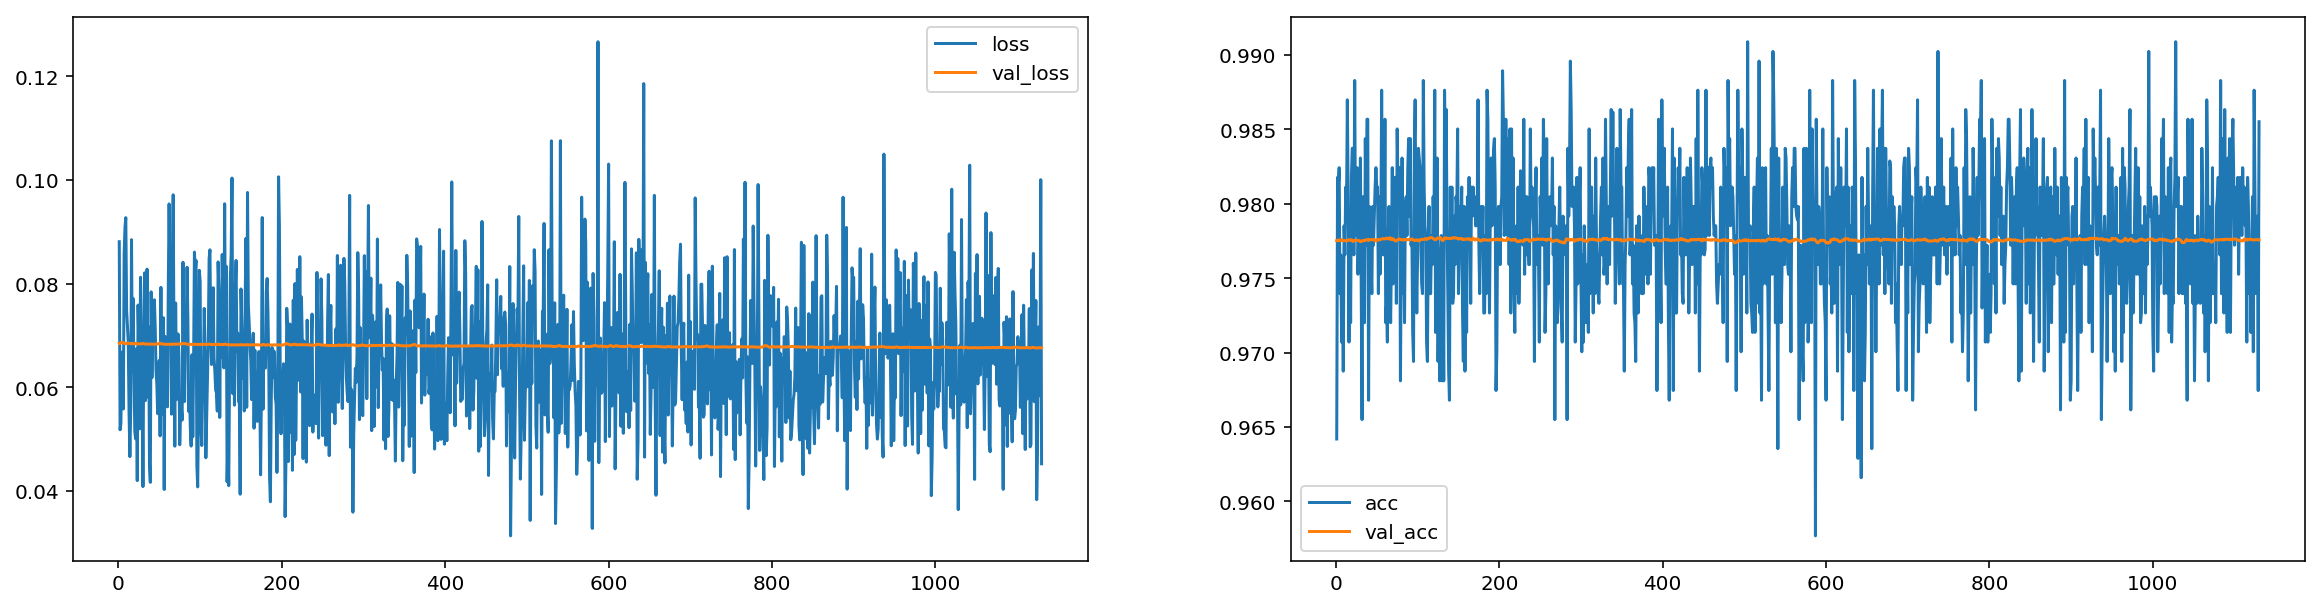

Epoch 00010: val_loss improved from 0.06763 to 0.06759, saving model to basic_model_best.hdf5
143613/143613 [==============================] - 70s 485us/step - loss: 0.0653 - acc: 0.9780 - val_loss: 0.0676 - val_acc: 0.9776


In [268]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='basic_model_best.hdf5', verbose=1, save_best_only=True)

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=5, 
                         x_val=dense_matrix_valid, 
                         y_val_categorical=Y_valid)
history = model_sig_nn.fit(dense_matrix_train, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(dense_matrix_valid, Y_valid), 
          callbacks=[plot_losses, checkpointer],
         )

# Evaluo valid

In [269]:
#model_sig_nn.load_weights('basic_model_best.hdf5')

In [270]:
tfidf_matrix_valid.shape, Y_valid.shape

((15958, 177900), (15958, 6))

In [271]:
pred_valid = model_sig_nn.predict(dense_matrix_valid, verbose = 1)
pred_train = model_sig_nn.predict(dense_matrix_train, verbose = 1)

143613/143613 [==============================] - 10s 70us/step


In [272]:
model_sig_nn.evaluate(dense_matrix_valid, Y_valid)

15958/15958 [==============================] - 1s 76us/step


[0.067588977111373461, 0.97757655386638487]

[0.073181636426992352, 0.97782721309109666]

# ROC Curve

In [273]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_train, pred_train, average='macro'))
print(roc_auc_score(Y_valid, pred_valid, average='macro'))

0.952783718152
0.953216326181


0.930758815168  
0.920441587397

In [266]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

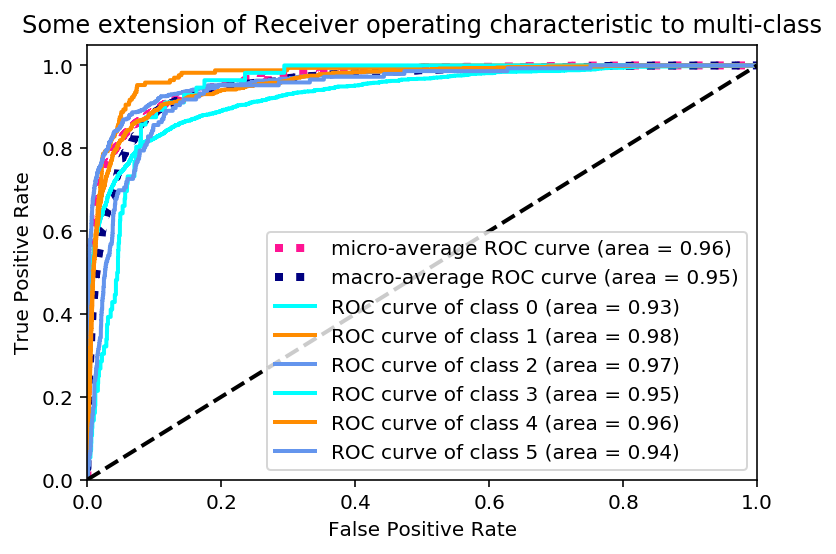

In [267]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

**True Positive Rate**:   
The number of times your system was able to classify the positives as positives. 

True positive rate = Correctly Classified Positives/(Correctly Classified as Positives+ Falsely Classified as Negatives)

**False Positive Rate**:  
The number of times your system classified a negative as a positive divided by the total  actual negative instances.


False positive rate = Incorrectly Classified as Positives/(Incorrectly Classified as Positives+ Correctly classified as Negatives )

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001

Macro-average: Calcula el score de cada clase y luego promedia  
Micro-average: Suma y luego calcula el score

Micro-average se considera mejor cuando hay desbalce en las clases

# Interpretación

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

In [49]:
(model_sig_nn.get_weights()[0]).shape

(10000, 6)

In [58]:
salida = 2
sorted_indexes = np.argsort(model_sig_nn.get_weights()[0][:,salida])[::-1]
np.array(tfidf_vectorizer.get_feature_names())[sorted_indexes][:20]

array(['fuck', 'fucking', 'shit', 'ass', 'bullshit', 'asshole', 'bitch',
       'dick', 'suck', 'cunt', 'faggot', 'stupid', 'cock', 'bastard',
       'fuckin', 'fucked', 'motherfucker', 'fucker', 'idiot', 'pussy'],
      dtype='<U21')

# Predict for test

In [51]:
tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)

In [52]:
dense_matrix_test = tfidf_matrix_test.todense()

In [53]:
pred = model_sig_nn.predict(dense_matrix_test, verbose=1)

  8512/153164 [>.............................] - ETA: 52s

KeyboardInterrupt: 

In [ ]:
pred.shape

In [ ]:
1*(pred[0:10]>0.5)

In [ ]:
submission[list_classes] = pred
submission.to_csv("submission_early_stop_2_epochs.csv", index = False)

Submit1 ROC AUC en valid = 0.731196488262  
Submit2 ROC AUC en valid = 0.963410980044  
Submit3 ROC AUC en valid = 0.974042855266

In [ ]:
# ~/.local/bin/kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission_early_stop_2_epochs.csv -m "Early stop 2 epochs"